In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold as kf

from mpl_toolkits.mplot3d import Axes3D


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv("../Merging/Merged_Data.csv")
print(data.columns)
data.head(5)

Index(['period', 'plantCode', 'plantName', 'fuel2002', 'fuelTypeDescription',
       'state', 'stateDescription', 'primeMover', 'total-consumption',
       'total-consumption-units', 'total-consumption-btu', 'generation',
       'gross-generation', 'consumption-for-eg', 'consumption-for-eg-units',
       'consumption-for-eg-btu', 'average-heat-content',
       'average-heat-content-units', 'total-consumption-btu-units',
       'generation-units', 'gross-generation-units',
       'consumption-for-eg-btu-units', 'X', 'Y', 'FID', 'OBJECTID',
       'Plant_Code', 'Plant_Name', 'Utility_ID', 'Utility_Na', 'sector_nam',
       'Street_Add', 'City', 'County', 'State', 'Zip', 'PrimSource',
       'source_des', 'tech_desc', 'Install_MW', 'Total_MW', 'Bat_MW', 'Bio_MW',
       'Coal_MW', 'Geo_MW', 'Hydro_MW', 'HydroPS_MW', 'NG_MW', 'Nuclear_MW',
       'Crude_MW', 'Solar_MW', 'Wind_MW', 'Other_MW', 'Source', 'Period',
       'Longitude', 'Latitude', 'LATITUDE', 'LONGITUDE', 'DATE', 'ELEVATION',


,period,plantCode,plantName,fuel2002,fuelTypeDescription,state,stateDescription,primeMover,total-consumption,total-consumption-units,...,TEMPEXT_BASE40,TEMPEXT_BASE45,TEMPEXT_BASE50,OVER_60,OVER_70,OVER_80,UNDER_40,UNDER_30,UNDER_20,SUM_OVER_UNDER
0,2020-01-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,84432,MMBtu per Mcf,...,23.723333,18.723333,14.123333,0.600000,0.300000,0.0,0.0,0.0,0.0,0.900000
1,2020-12-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,11343,MMBtu per Mcf,...,17.293548,12.487097,8.706452,0.354839,0.032258,0.0,0.0,0.0,0.0,0.387097
2,2023-08-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,109965,MMBtu per Mcf,...,46.403226,41.403226,36.403226,1.000000,1.000000,1.0,0.0,0.0,0.0,3.000000
3,2023-04-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,12548,MMBtu per Mcf,...,32.903333,27.903333,22.903333,1.000000,0.833333,0.0,0.0,0.0,0.0,1.833333
4,2023-02-01,57950,MSC Croswell,NG,Natural Gas,MI,Michigan,ALL,96587,MMBtu per Mcf,...,25.867857,20.867857,15.867857,0.785714,0.357143,0.0,0.0,0.0,0.0,1.142857


In [3]:

data['period'] = pd.to_datetime(data['period'])
data.sort_values(by='period', inplace=True)
plant_codes = data['plantCode'].unique()
data = data[data['period'] >= '2019-01-01']

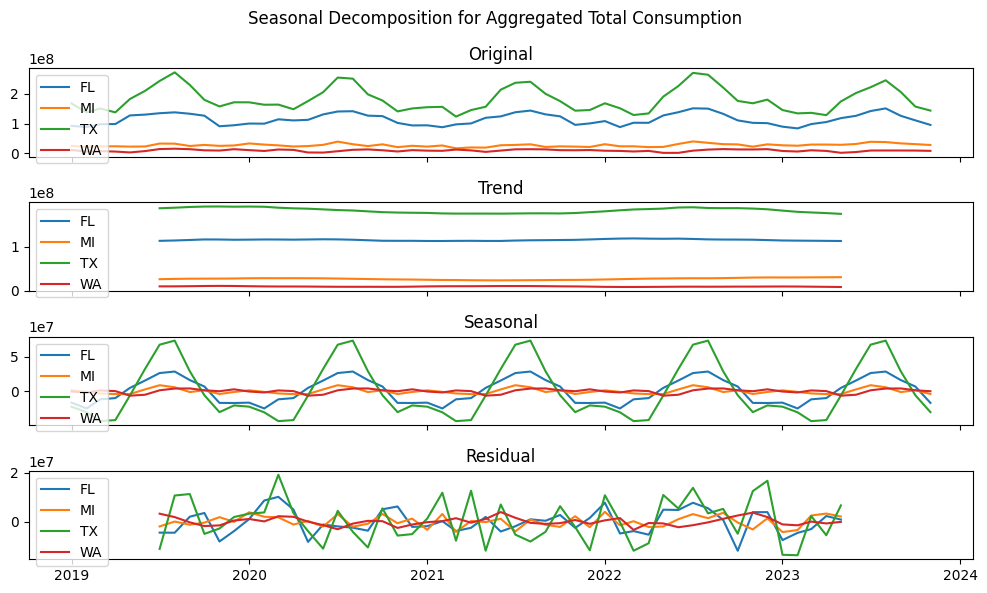

In [4]:
# Convert 'period' column to datetime
data['period'] = pd.to_datetime(data['period'])

# Group by 'period' and 'state', then sum 'total-consumption'
aggregated_data = data.groupby(['period', 'state'])['total-consumption'].sum().unstack().fillna(0)

# Perform seasonal decomposition on each state's total consumption
results = {}
for state, consumption in aggregated_data.items():
    result = seasonal_decompose(consumption, model='additive', period=12)
    results[state] = result

# Plot the decomposed components for aggregated total consumption of each state
fig, axs = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

for state, result in results.items():
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    axs[0].plot(aggregated_data.index, aggregated_data[state], label=state)
    axs[1].plot(trend, label=state)
    axs[2].plot(seasonal, label=state)
    axs[3].plot(residual, label=state)

axs[0].set_title("Original")
axs[1].set_title("Trend")
axs[2].set_title("Seasonal")
axs[3].set_title("Residual")

for ax in axs:
    ax.legend(loc='upper left')

plt.suptitle("Seasonal Decomposition for Aggregated Total Consumption")
plt.tight_layout()
plt.show()

# plot on separate axes

In [5]:
# Define the time periods and features for training and testing
start_train = '2019-01-01'
end_train = '2022-12-31'
start_test = '2023-01-01'
end_test = '2023-12-31'
model_features = ['ELEVATION', 'TEMP',
       'WDSP', 'MXSPD', 'GUST', 'MAX', 'MIN', 'PRCP', 'SNDP','TEMPEXT_BASE40', 'TEMPEXT_BASE45', 'TEMPEXT_BASE50', 
       'OVER_60', 'OVER_70', 'OVER_80', 'UNDER_40', 'UNDER_30', 'UNDER_20',
       'SUM_OVER_UNDER', 'LATITUDE','LONGITUDE','Zip','plantCode']

print(data[model_features].head())

       ELEVATION       TEMP      WDSP      MXSPD       GUST        MAX  \
15891       11.0  52.854839  6.587097  11.509677   0.000000  60.874194   
20500        3.5  69.029032  8.190323  12.958065   0.000000  74.422581   
17705        7.0  56.264516  3.254839   9.187097   0.000000  63.919355   
13435       30.5  52.141935  5.370968  11.825806  10.464516  63.835484   
506        206.5  23.809677  8.809677  15.496774  18.154839  31.322581   

             MIN      PRCP  SNDP  TEMPEXT_BASE40  ...   OVER_70  OVER_80  \
15891  46.848387  0.000000   0.0       12.854839  ...  0.000000      0.0   
20500  64.070968  0.000000   0.0       29.029032  ...  0.516129      0.0   
17705  50.429032  0.000000   0.0       16.264516  ...  0.032258      0.0   
13435  43.796774  0.073871   0.0       12.141935  ...  0.000000      0.0   
506    16.512903  0.067742   0.0       16.287097  ...  0.000000      0.0   

       UNDER_40  UNDER_30  UNDER_20  SUM_OVER_UNDER  LATITUDE  LONGITUDE  \
15891  0.032258  0.000

In [10]:

def train_test_and_plot(data, model, start_train, end_train, start_test, end_test, model_features):
    # Exclude negative consumption values
    data = data[data['total-consumption'] > 0]

    # Convert 'state' column to categorical type
    data['state'] = data['state'].astype('category')
    
    # Extract features and target variable
    X = data[model_features].fillna(0)
    y = data['total-consumption']

    # Filter the data for training and testing
    train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
    test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

    # Extract features and target variable for training
    X_train = train_data[model_features]
    y_train = train_data['total-consumption']

    # Extract features and target variable for testing
    X_test = test_data[model_features]
    y_test = test_data['total-consumption']

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Could use mean absolute error as an option (evaluating against the median instead of the average)
    # Reasonable baseline approach to use a combination of a squared error and R2 terms

    print('Model evaluation:')
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

    # Plotting the predicted vs. actual total consumption
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, c=test_data['state'].cat.codes, cmap='viridis', alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=2)  # Plotting the diagonal line
    plt.title('Predicted vs. Actual Total Consumption')
    plt.xlabel('Actual Total Consumption')
    plt.ylabel('Predicted Total Consumption')
    plt.grid(True)

    plt.show()


    # Plotting predicted and actual values against timescale 'period'
    plt.figure(figsize=(12, 6))
    plt.scatter(test_data['period'], y_test, label='Actual', alpha=0.5)
    plt.scatter(test_data['period'], y_pred, label='Predicted', alpha=0.5)
    plt.title('Actual vs. Predicted Total Consumption Over Time')
    plt.xlabel('Period')
    plt.ylabel('Total Consumption')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


    # Perform PCA on the entire dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=20)  # Specify the number of components to retain
    pca.fit(X_scaled)

    # Visualize explained variance ratio
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center')
    plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio by Principal Components')
    plt.show()

    # Feature Importance
    if hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
        sorted_idx = np.argsort(feature_importance)
        print(feature_importance)
        top_features = np.array(model_features)[sorted_idx][-10:]  # Adjust the number of top features as needed
        pos = np.arange(top_features.shape[0]) + .5
        plt.figure(figsize=(10, 6))
        plt.barh(pos, feature_importance[sorted_idx][-10:], align='center')
        plt.yticks(pos, top_features)
        plt.xlabel('Feature Importance')
        plt.title('Top 10 Feature Importance')
        plt.show()

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_4468\883805246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 494308647565.3956
R-squared: 0.8725811137310058


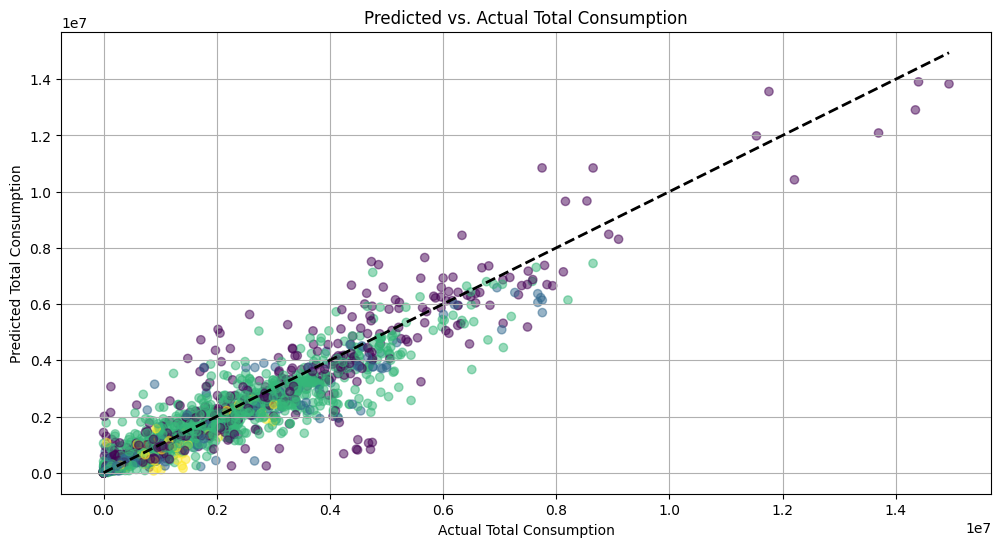

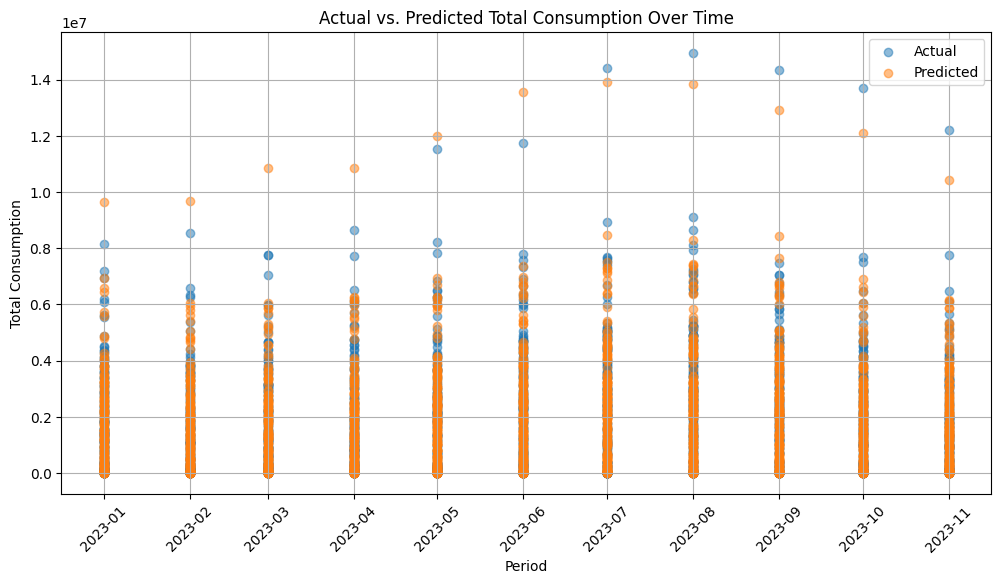

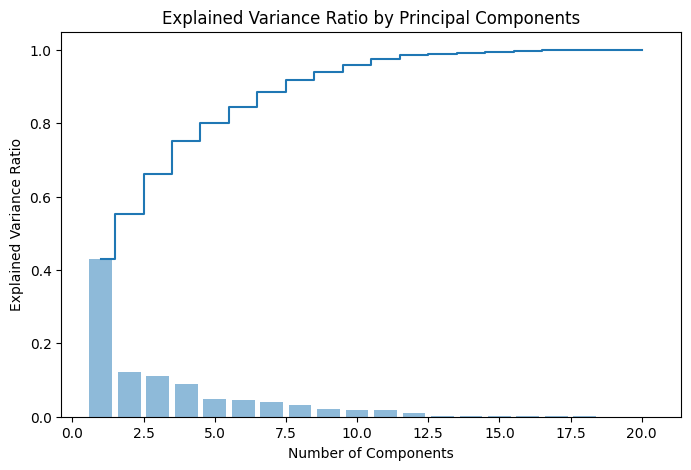

[9.64117035e-02 2.55284249e-03 1.58507099e-02 7.70131850e-03
 9.47473215e-03 1.86125816e-02 1.38841474e-02 1.50356398e-02
 2.88147329e-05 3.09680112e-03 3.25057711e-03 3.20829383e-03
 1.99616790e-03 4.15008606e-03 3.45193176e-03 8.60328162e-04
 2.21436480e-04 5.80333404e-05 4.29676387e-03 1.07478477e-01
 6.43444489e-02 1.59360022e-01 4.64674143e-01]


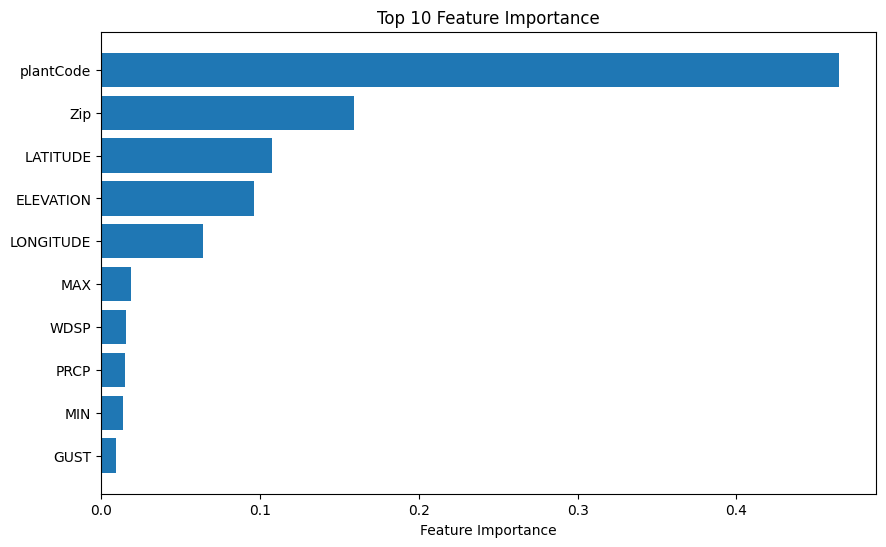

In [11]:
rf_model = RandomForestRegressor(n_estimators = 150,
                                 max_depth = 20,
                                 min_samples_split = 10)


# Call the function with the model and other parameters
train_test_and_plot(data, rf_model, start_train, end_train, start_test, end_test, model_features)

C:\Users\nicoesse\AppData\Local\Temp\ipykernel_4468\883805246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 506695297495.6475
R-squared: 0.8693881832684494


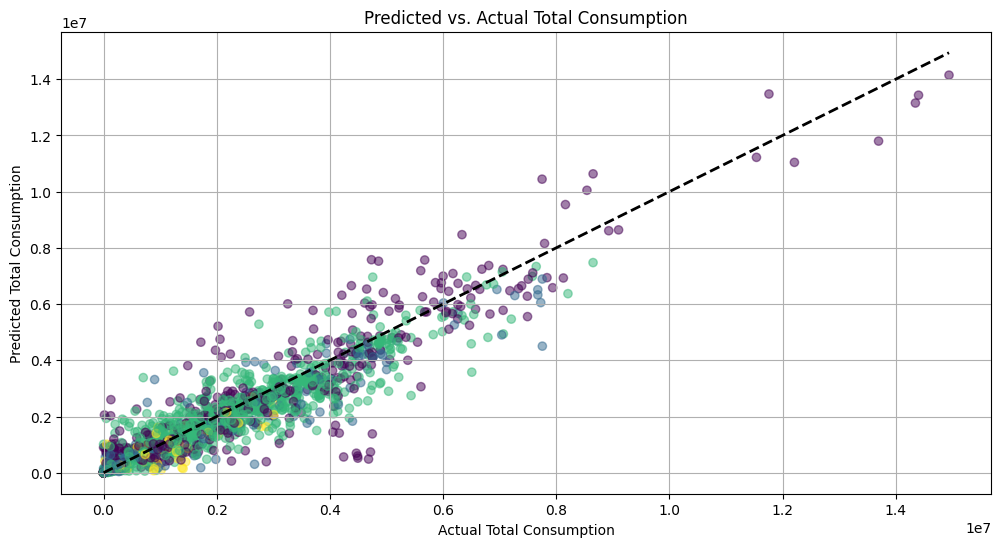

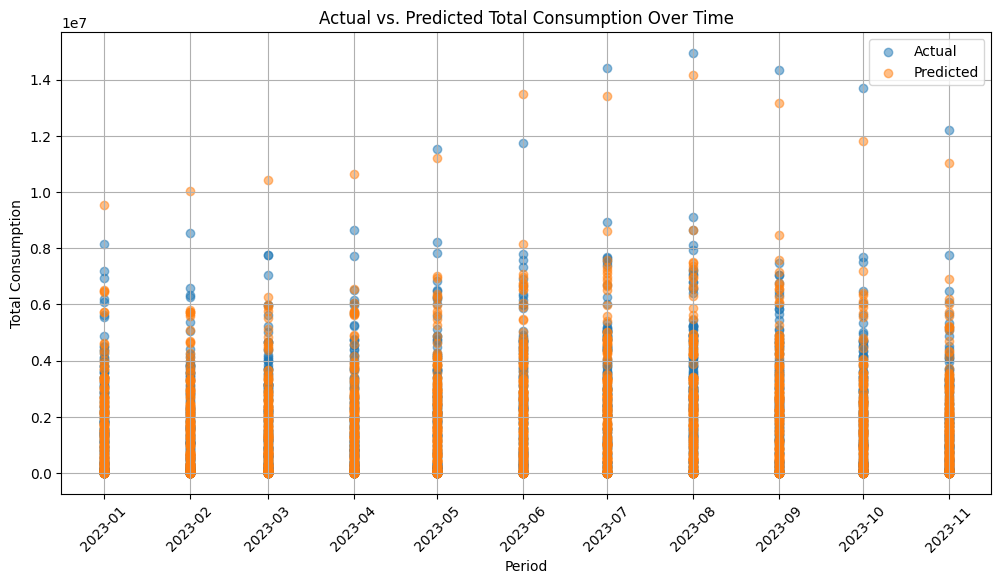

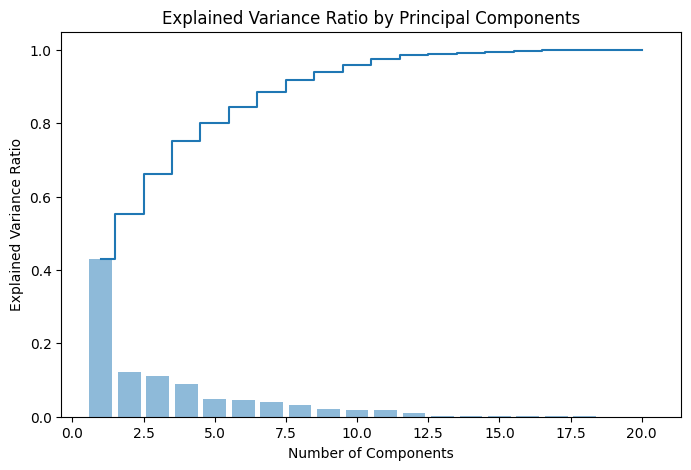

In [12]:
knn_model = KNeighborsRegressor(n_neighbors = 7,
                                weights = 'distance',
                                algorithm = 'ball_tree')

# Call the train_test_and_plot function
train_test_and_plot(data, knn_model, start_train, end_train, start_test, end_test, model_features)


C:\Users\nicoesse\AppData\Local\Temp\ipykernel_4468\883805246.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['state'].astype('category')


Model evaluation:
Mean Squared Error: 1047925036788.3346
R-squared: 0.7298743573704132


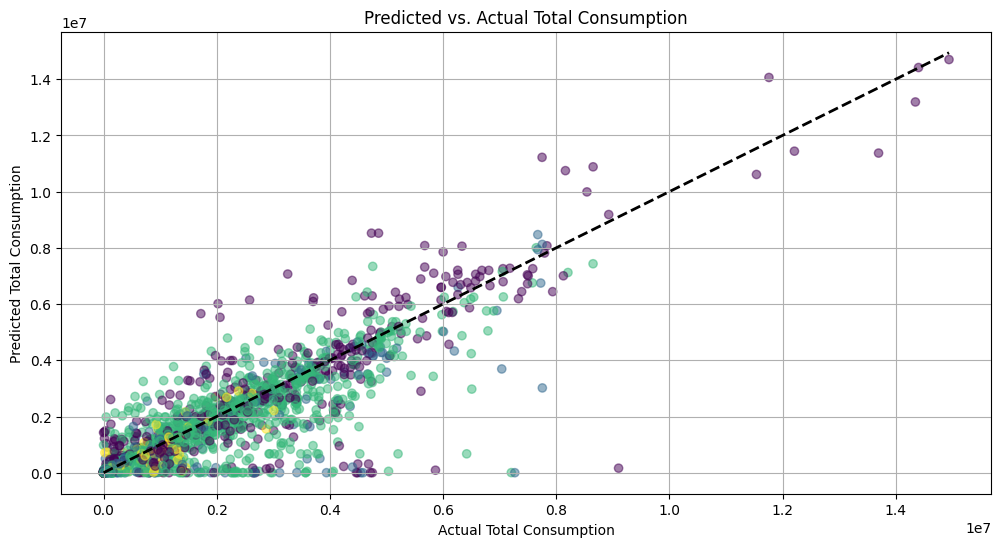

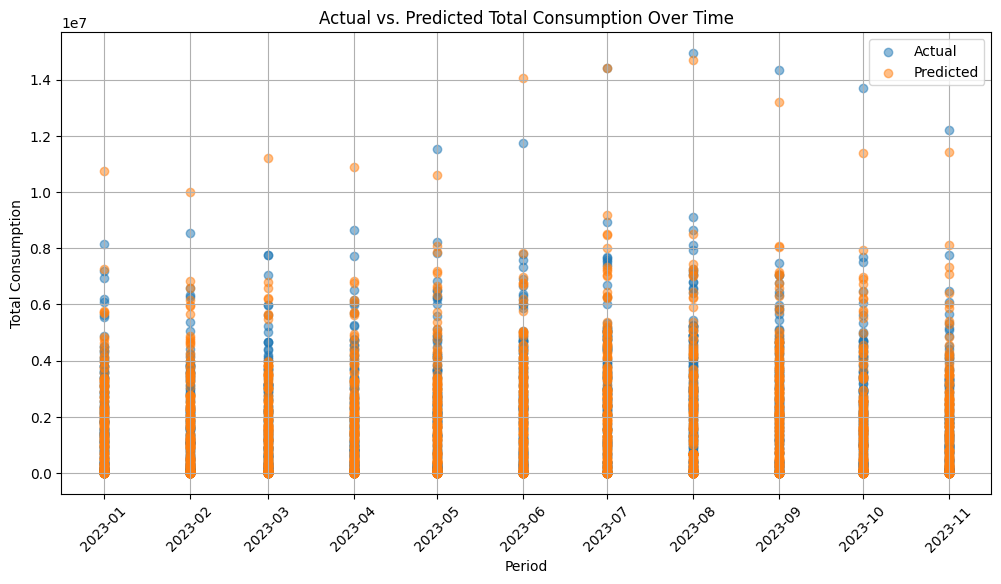

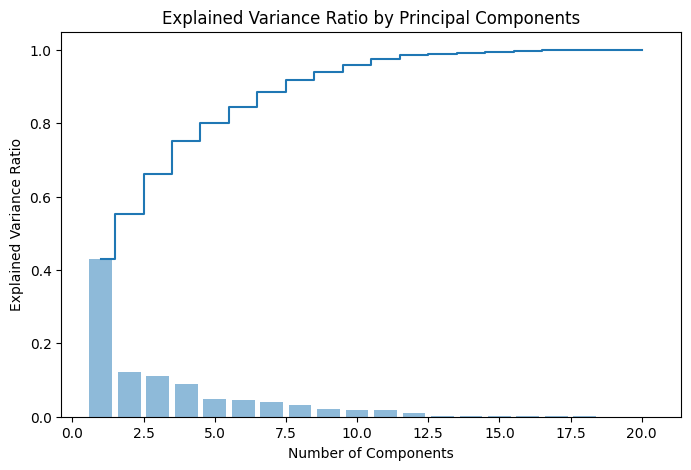

In [13]:
nb_model = GaussianNB()
train_test_and_plot(data, nb_model, start_train, end_train, start_test, end_test, model_features)


In [58]:
# Sensitivity Analysis on RandomForest


# Define ranges for hyperparameters
n_estimators_range = [50, 100, 150]
max_depth_range = [10, 20]
min_samples_split_range = [2, 5, 10]

# Initialize lists to store results
mse_results = []
std_results = []

# Exclude negative consumption values
data = data[data['total-consumption'] > 0]

# Convert 'state' column to categorical type
data['state'] = data['state'].astype('category')
    
# Extract features and target variable
X = data[model_features].fillna(0)
y = data['total-consumption']
# Filter the data for training and testing
train_data = data[(data['period'] >= start_train) & (data['period'] <= end_train)]
test_data = data[(data['period'] >= start_test) & (data['period'] <= end_test)]

# Extract features and target variable for training
X_train = train_data[model_features]
y_train = train_data['total-consumption']

# Extract features and target variable for testing
X_test = test_data[model_features]
y_test = test_data['total-consumption']

# Perform sensitivity analysis
for n_estimators in n_estimators_range:
    for max_depth in max_depth_range:
        for min_samples_split in min_samples_split_range:
            # Create Random Forest model with current hyperparameters
            rf_model = RandomForestRegressor(n_estimators=n_estimators,
                                              max_depth=max_depth,
                                              min_samples_split=min_samples_split)
            # Perform k-fold cross-validation
            mse_scores = []
            kfolder = kf(n_splits=5, random_state=None, shuffle=False)
            for train_index, test_index in kf.split(kfolder, X_train):
                X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
                y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
                
                # Train model on current fold
                rf_model.fit(X_train_fold, y_train_fold)
                
                # Predict on test fold and calculate MSE
                y_pred_fold = rf_model.predict(X_test_fold)
                mse_fold = mean_squared_error(y_test_fold, y_pred_fold)
                mse_scores.append(mse_fold)
            
            # Calculate mean MSE and standard deviation
            mean_mse = np.mean(mse_scores)
            std_mse = np.std(mse_scores)
            
            # Store results
            mse_results.append(mean_mse)
            std_results.append(std_mse)



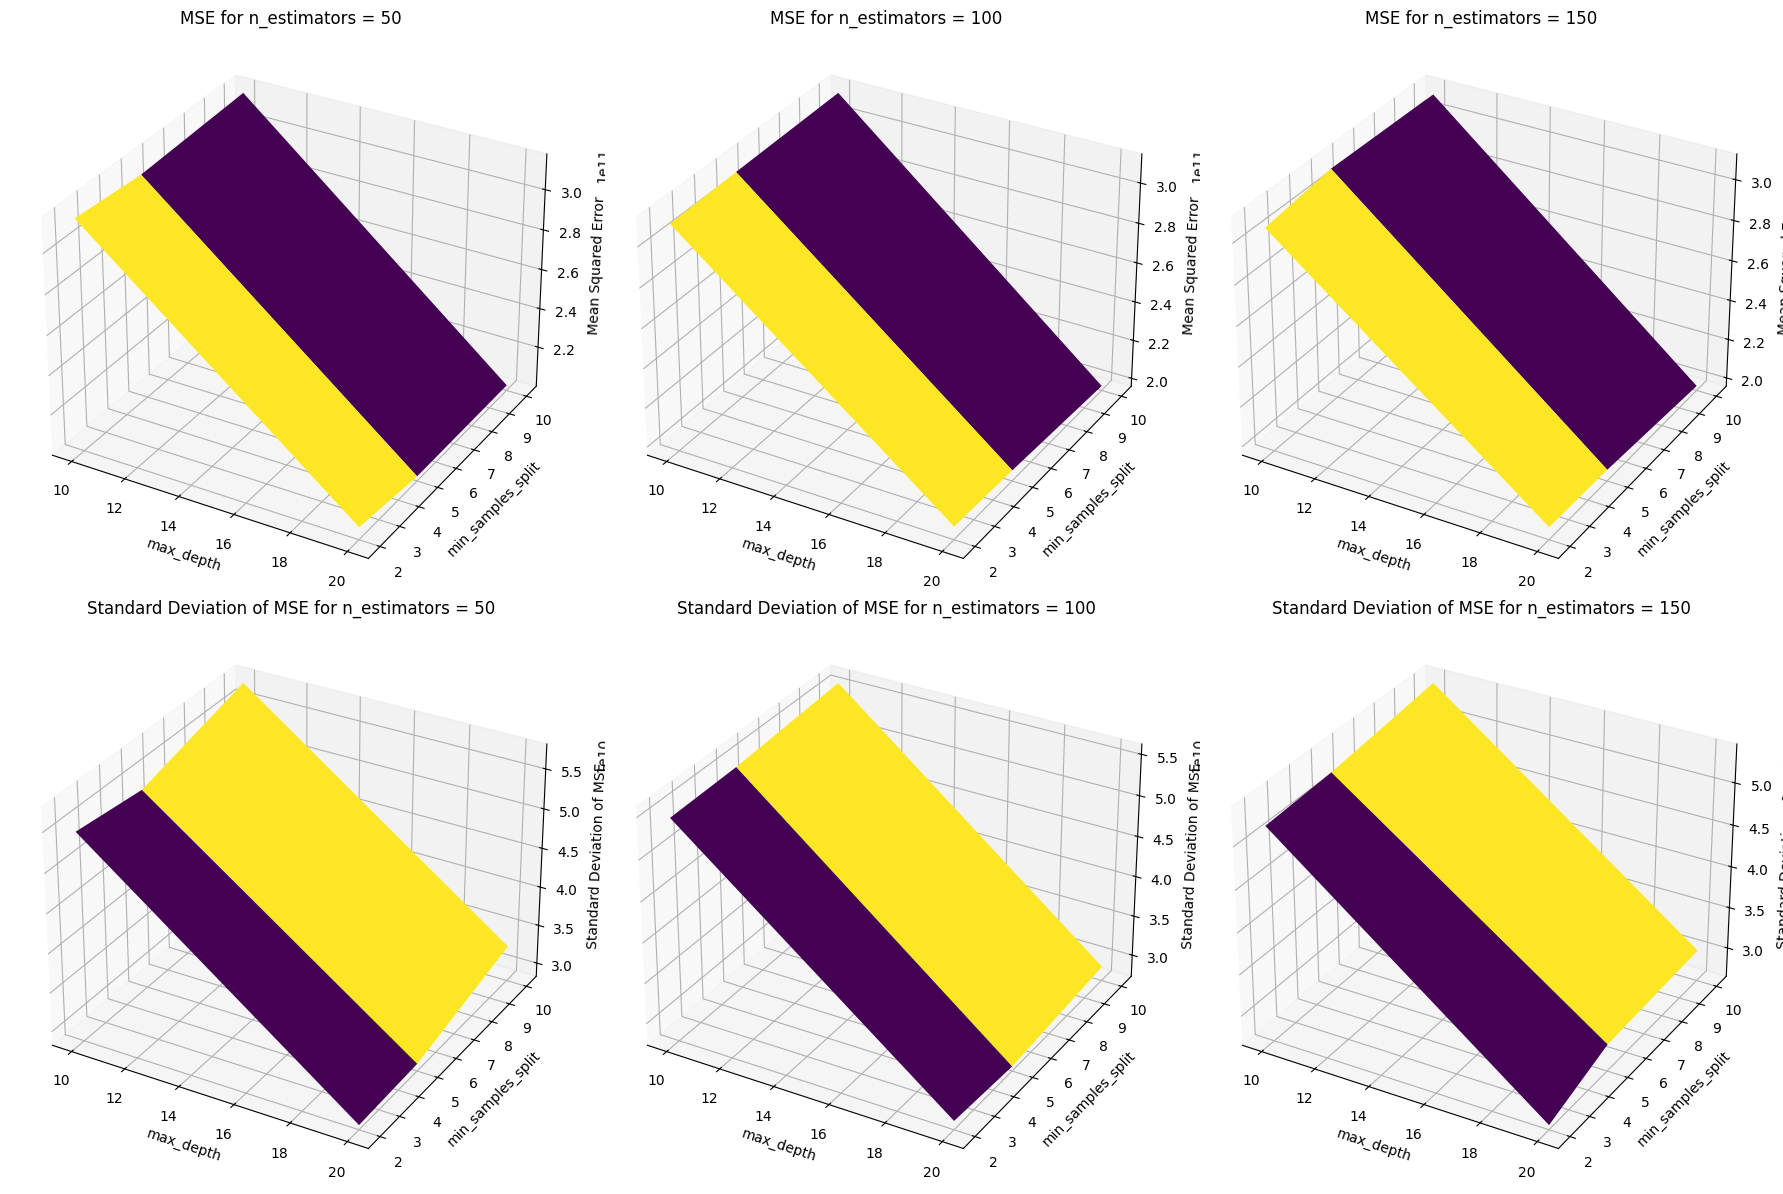

In [71]:
# Reshape mse_results and std_results into 3D arrays
mse_results_3d = np.array(mse_results).reshape(len(n_estimators_range), len(max_depth_range), len(min_samples_split_range))
std_results_3d = np.array(std_results).reshape(len(n_estimators_range), len(max_depth_range), len(min_samples_split_range))

# Create meshgrid for 3D plotting
MAX_DEPTH_VALUES, MIN_SAMPLES_SPLIT = np.meshgrid(max_depth_range, min_samples_split_range)

# Create a figure with multiple subplots
fig = plt.figure(figsize=(18, 12))

# Plot MSE surface plots
for i in range(3):
    mse_slice = mse_results_3d[i].T
    ax = fig.add_subplot(2, 3, i+1, projection='3d')
    surf = ax.plot_surface(MAX_DEPTH_VALUES, MIN_SAMPLES_SPLIT, mse_slice, cmap='viridis')
    ax.set_xlabel('max_depth')
    ax.set_ylabel('min_samples_split')
    ax.set_zlabel('Mean Squared Error')
    ax.set_title(f'MSE for n_estimators = {n_estimators_range[i]}')

# Plot Standard Deviation surface plots
for i in range(3):
    std_slice = std_results_3d[i].T
    ax = fig.add_subplot(2, 3, i+4, projection='3d')
    surf = ax.plot_surface(MAX_DEPTH_VALUES, MIN_SAMPLES_SPLIT, std_slice, cmap='viridis')
    ax.set_xlabel('max_depth')
    ax.set_ylabel('min_samples_split')
    ax.set_zlabel('Standard Deviation of MSE')
    ax.set_title(f'Standard Deviation of MSE for n_estimators = {n_estimators_range[i]}')

plt.tight_layout()
plt.show()